In [ ]:
# HIDDEN
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
# HIDDEN
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]
    if len(df.columns) <= ncols:
        interact(peek, row=(0, len(df) - nrows, nrows), col=fixed(0))
    else:
        interact(peek,
                 row=(0, len(df) - nrows, nrows),
                 col=(0, len(df.columns) - ncols))
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

In [4]:
# HIDDEN
def jitter_df(df, x_col, y_col):
    x_jittered = df[x_col] + np.random.normal(scale=0, size=len(df))
    y_jittered = df[y_col] + np.random.normal(scale=0.05, size=len(df))
    return df.assign(**{x_col: x_jittered, y_col: y_jittered})

In [5]:
# HIDDEN
lebron = pd.read_csv('lebron.csv')

## The Logistic Model

In this section, we introduce the **logistic model**, a regression model that we use to predict probabilities.

Recall that fitting a model requires three components: a model that makes predictions, a loss function, and an optimization method. For the by-now familiar least squares linear regression, we select the model:

$$
\begin{aligned}
f_\hat{\boldsymbol{\theta}} (\textbf{x}) &= \hat{\boldsymbol{\theta}} \cdot \textbf{x}
\end{aligned}
$$

And the loss function:

$$
\begin{aligned}
L(\boldsymbol{\theta}, \textbf{X}, \textbf{y})
&= \frac{1}{n} \sum_{i}(y_i - f_\boldsymbol{\theta} (\textbf{X}_i))^2\\
\end{aligned}
$$

We use gradient descent as our optimization method. In the definitions above, $ \textbf{X} $ represents the $ n \times p $ data matrix ($n$ is the number of data points and $p$ is the number of attributes), $ \textbf{x} $ represents a row of $ \textbf{X} $, and $ \textbf{y} $ is the vector of observed outcomes. The vector $ \boldsymbol{\hat{\theta}} $ contains the optimal model weights whereas $\boldsymbol{\theta}$ contains intermediate weight values generated during optimization.

## Real Numbers to Probabilities

Observe that the model $ f_\hat{\boldsymbol{\theta}} (\textbf{x}) = \hat{\boldsymbol{\theta}} \cdot \textbf{x} $ can output any real number $ \mathbb{R} $ since it produces a linear combination of the values in $ \textbf{x} $, which itself can contain any value from $ \mathbb{R} $.

We can easily visualize this when $ x $ is a scalar. If $ \hat \theta = 0.5$, our model becomes $ f_\hat{\theta} (\textbf{x}) = 0.5 x $. Its predictions can take on any value from negative infinity to positive infinity:

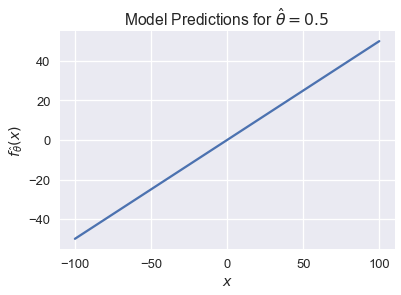

In [6]:
# HIDDEN
xs = np.linspace(-100, 100, 100)
ys = 0.5 * xs
plt.plot(xs, ys)
plt.xlabel('$x$')
plt.ylabel(r'$f_\hat{\theta}(x)$')
plt.title(r'Model Predictions for $ \hat{\theta} = 0.5 $');

For classification tasks, we want to constrain $ f_\hat{\boldsymbol{\theta}}(\textbf{x}) $ so that its output can be interpreted as a probability. This means that it may only output values in the range $ [0, 1] $. In addition, we would like large values of $ f_\hat{\boldsymbol{\theta}}(\textbf{x}) $ to correspond to high probabilities and small values to low probabilities.

## The Logistic Function

To accomplish this, we introduce the **logistic function**, often called the **sigmoid function**:

$$
\begin{aligned}
\sigma(t) = \frac{1}{1 + e^{-t}}
\end{aligned}
$$

For ease of reading, we often replace $ e^x $ with $ \text{exp}(x) $ and write:

$$
\begin{aligned}
\sigma (t) = \frac{1}{1 + \text{exp}(-t)}
\end{aligned}
$$

We plot the sigmoid function for values of $ t \in [-10, 10] $ below.

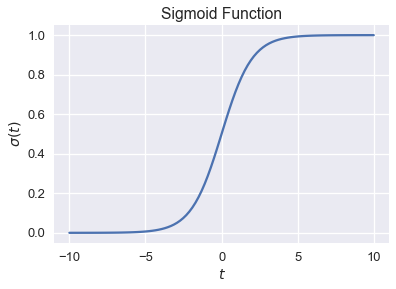

In [7]:
# HIDDEN
from scipy.special import expit
xs = np.linspace(-10, 10, 100)
ys = expit(xs)
plt.plot(xs, ys)
plt.title(r'Sigmoid Function')
plt.xlabel('$ t $')
plt.ylabel(r'$ \sigma(t) $');

Observe that the sigmoid function $ \sigma(t) $ takes in any real number $ \mathbb{R} $ and outputs only numbers between 0 and 1. The function is monotonically increasing on its input $ t $; large values of $ t $ correspond to values closer to 1, as desired. This is not a coincidence—the sigmoid function may be derived from a log ratio of probabilities, although we omit the derivation for brevity.

## Logistic Model Definition

We may now take our linear model $ \hat{\boldsymbol{\theta}} \cdot \textbf{x} $ and use it as the input to the sigmoid function to create the **logistic model**:

$$
\begin{aligned}
f_\hat{\boldsymbol{\theta}} (\textbf{x}) = \sigma(\hat{\boldsymbol{\theta}} \cdot \textbf{x})
\end{aligned}
$$

In other words, we take the output of linear regression—any number in $ \mathbb{R} $— and use the sigmoid function to restrict the model's final output to be a valid probability between zero and one.

To develop some intuition for how the logistic model behaves, we restrict $ x $ to be a scalar and plot the logistic model's output for several values of $ \hat{\theta} $.

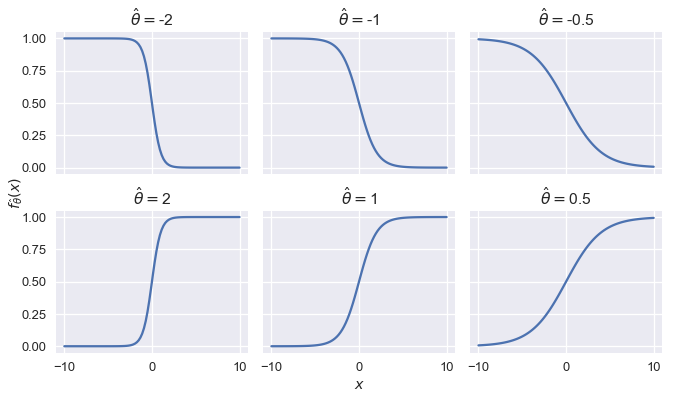

In [24]:
# HIDDEN
def flatten(li): return [item for sub in li for item in sub]

thetas = [-2, -1, -0.5, 2, 1, 0.5]
xs = np.linspace(-10, 10, 100)

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 6))
for ax, theta in zip(flatten(axes), thetas):
    ys = expit(theta * xs)
    ax.plot(xs, ys)
    ax.set_title(r'$ \hat{\theta} = $' + str(theta))

# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off',
                left='off', right='off')
plt.grid(False)
plt.xlabel('$x$')
plt.ylabel(r'$ f_\hat{\theta}(x) $')
plt.tight_layout()

We see that changing the magnitude of $ \hat{\theta} $ changes the sharpness of the curve; the further away from $ 0 $, the sharper the curve. Flipping the sign of $ \hat{\theta} $ while keeping magnitude constant is equivalent to reflecting the curve over the y-axis.

## Summary

We introduce the logistic model, a new prediction function that outputs probabilities. To construct the model, we use the output of linear regression as the input to the nonlinear logistic function.